In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from scipy.stats import pearsonr
import torch.nn.functional as F

In [ ]:
train_data = torch.load('train.pt')
val_data = torch.load('val.pt')
test_data = torch.load('test.pt')

In [ ]:
X_train, y_train = train_data[:][:1], train_data[:][1:] 
X_val, y_val = val_data[:][:1], val_data[:][1:] 
X_test, y_test = test_data[:][:1], test_data[:][1:] 

In [ ]:
def prepare_dataset(data):
    eeg_list = []
    stim_list = []
    for eeg, stim in data:
        eeg_list.append(eeg.float())           # (320, 64)
        stim_list.append(stim.float())         # (320,)
    eeg_tensor = torch.stack(eeg_list)         # (N, 320, 64)
    stim_tensor = torch.stack(stim_list)       # (N, 320)
    return eeg_tensor, stim_tensor

In [ ]:
X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)

In [ ]:
class EEGTransformer(nn.Module):
    def __init__(self, n_channels, d_model=64, nhead=8, num_layers=3, dim_feedforward=256, dropout=0.1):
        super(EEGTransformer, self).__init__()

        # Input projection: project EEG channels to d_model features
        self.input_proj = nn.Linear(n_channels, d_model)

        # Positional encoding (learned)
        self.pos_embedding = nn.Parameter(torch.randn(1, 1000, d_model))  # max seq length=1000, adjust if needed

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output projection to scalar envelope value per time step
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        x: (batch_size, seq_len, n_channels)
        """

        batch_size, seq_len, _ = x.size()
        x = self.input_proj(x)  # (batch_size, seq_len, d_model)

        # Add positional embeddings (trim to seq_len)
        pos_emb = self.pos_embedding[:, :seq_len, :]  # (1, seq_len, d_model)
        x = x + pos_emb

        # Transformer expects shape (seq_len, batch_size, d_model)
        x = x.permute(1, 0, 2)

        # Pass through transformer encoder
        x = self.transformer_encoder(x)  # (seq_len, batch_size, d_model)

        # Back to (batch_size, seq_len, d_model)
        x = x.permute(1, 0, 2)

        # Output projection
        out = self.output_proj(x)  # (batch_size, seq_len, 1)

        # Return (batch_size, seq_len) for convenience
        return out.squeeze(-1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 1. Setup logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s │ %(message)s",
    datefmt="%H:%M:%S"
)
logger = logging.getLogger(__name__)

In [ ]:
# 2. Hyperparameters
n_channels      = 64
d_model         = 64
nhead           = 8
num_layers      = 3
dim_feedforward = 256
dropout         = 0.1
lr              = 1e-4
weight_decay    = 1e-4
num_epochs      = 1
batch_size      = 32  # adjust if needed

In [15]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

In [ ]:
model     = EEGTransformer(n_channels, d_model, nhead, num_layers,
                           dim_feedforward, dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                 T_max=num_epochs,
                                                 eta_min=1e-6)

/home/uday.g/.conda/envs/usago_env/lib/python3.13/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [18]:
best_val_loss = float('inf')

# 6. Training loop with tqdm
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0

    # Wrap the train_loader in tqdm
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]", leave=False)
    for X_batch, y_batch in train_bar:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss    = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [Val]  ", leave=False)
    with torch.no_grad():
        for X_batch, y_batch in val_bar:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss    = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            val_bar.set_postfix(loss=loss.item())

    val_loss /= len(val_loader.dataset)
    scheduler.step()

    # Checkpoint
    status = ""
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_eeg_transformer.pth")
        status = " (improved!)"

    # Log end-of-epoch summary
    logger.info(
        f"Epoch {epoch:02d} │ "
        f"Train Loss: {train_loss:.4f} │ "
        f"Val Loss: {val_loss:.4f}{status}"
    )

Epoch 01 | Train Loss: 0.2367 | Val Loss: 0.2535 (improved)
Epoch 02 | Train Loss: 0.2291 | Val Loss: 0.2524 (improved)
Epoch 03 | Train Loss: 0.2263 | Val Loss: 0.2570 


KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load("best_eeg_transformer.pth"))
model.eval()
test_loss = 0.0
for X_batch, y_batch in tqdm(test_loader, desc="Testing"):
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    outputs = model(X_batch)
    loss    = criterion(outputs, y_batch)
    test_loss += loss.item() * X_batch.size(0)
test_loss /= len(test_loader.dataset)
logger.info(f"Test Loss: {test_loss:.4f}")

Training complete. Best Val Loss: 0.2524


In [22]:
def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            loss = criterion(y_pred, y)
            total_loss += loss.item()

            all_preds.append(y_pred.cpu())
            all_targets.append(y.cpu())

    # Concatenate all batches
    preds = torch.cat(all_preds, dim=0).numpy().flatten()
    targets = torch.cat(all_targets, dim=0).numpy().flatten()

    # Pearson correlation
    pearson_corr = pearsonr(preds, targets)[0]

    # Cosine similarity
    cosine_sim = F.cosine_similarity(
        torch.tensor(preds), torch.tensor(targets), dim=0
    ).item()

    return total_loss / len(data_loader), pearson_corr, cosine_sim

In [23]:
# Final Test Evaluation
model.eval()
with torch.no_grad():
    test_loss = sum(criterion(model(x.to(device)), y.to(device)).item() for x, y in test_loader) / len(test_loader)
print(f"\n✅ Final Test Loss: {test_loss:.4f}")


✅ Final Test Loss: 0.2320


In [24]:
val_loss, val_pearson, val_cosine = evaluate_model(model, val_loader, device)
print(
    f"val data: Epoch {epochs:02d} | Val Loss: {val_loss:.4f} | Pearson: {val_pearson:.4f} | Cosine: {val_cosine:.4f}"
)

val_loss, val_pearson, val_cosine = evaluate_model(model, test_loader, device)
print(
    f"test data: Epoch {epochs:02d} | test Loss: {val_loss:.4f} | Pearson: {val_pearson:.4f} | Cosine: {val_cosine:.4f}"
)

val data: Epoch 01 | Val Loss: 0.2539 | Pearson: 0.0776 | Cosine: 0.7734
test data: Epoch 01 | test Loss: 0.2320 | Pearson: 0.0953 | Cosine: 0.7724


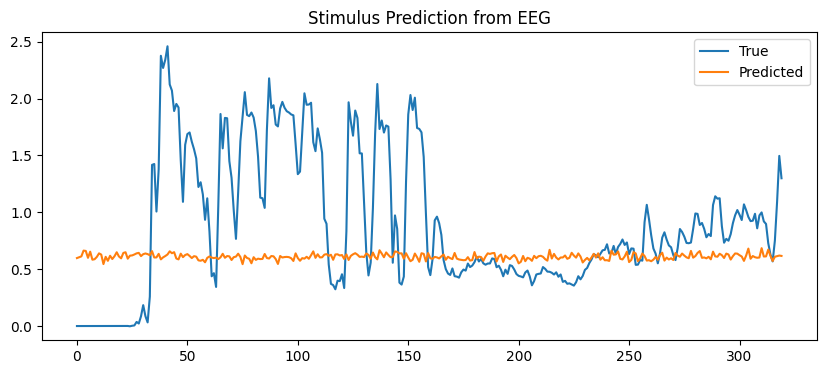

In [25]:
import matplotlib.pyplot as plt

x_sample, y_true = X_test[0:1], y_test[0:1]

model.eval()
with torch.no_grad():
    x_sample = x_sample.to(device)           # Move to GPU if available
    y_pred = model(x_sample).squeeze().cpu()  # Move prediction back to CPU for plotting

plt.figure(figsize=(10, 4))
plt.plot(y_true.squeeze().numpy(), label='True')
plt.plot(y_pred.numpy(), label='Predicted')
plt.legend()
plt.title("Stimulus Prediction from EEG")
plt.show()
